# Chap02 End-to-End Machine Learning Project

Your task is to predict median house values in Californian districts, given a number of features from these districts.


In [1]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
# Load the data
housing = pd.read_csv("../data/housing.csv")
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


total_bedrooms      20433 non-null  float64， 207 districts are missing this feature.

 ocean_proximity     20640 non-null  object ，we can research this feature to find out how many categories there are.


In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


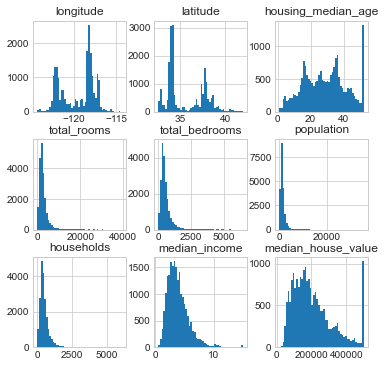

In [6]:
# pd histogram: a quick way to get a feel of the type of data 
# you are dealing with is to plot a histogram for each numerical attribute.
housing.hist(bins=50,figsize=(6,6))
plt.show()

In [7]:
labels = list(housing.iloc[:,i].name for i in range(0,9))

In [8]:
# # Xs = [] is not suggested
# Xs = []
# for i in range(0,9):
#     x = housing.iloc[:,i]
#     Xs.append(x)
#     labels = list(housing.iloc[:,i].name)

In [9]:
len(housing.columns[:-1])

9

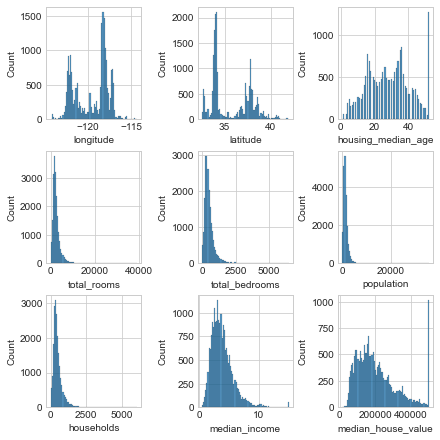

In [10]:
_, axes = plt.subplots(3, 3, figsize=(6, 6),constrained_layout=True)

for ax, col in zip(axes.flatten(), housing.columns[:-1]):
    sns.histplot(data=housing, x=col, bins=80, ax=ax)

$$\text{Figure 2-8. A histogram for each numerical attribute}$$


**There** are a few things you might notice in these histograms:

1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the **data has been scaled and capped at 15** (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

2. **The housing median age and the median house value were also capped**. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit.You need to check with your client team (the team that will use your system’s out‐put) to see if this is a problem or not. If they tell you that they need precise predictions even beyond $500,000, then you have two options:
        

- Collect proper labels for the districts whose labels were capped.

- **Remove those districts from the training set** (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond $500,000).

3. These attributes have very different scales. 
        

4. Finally, **many histograms are tail-heavy:** they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distribution


## Create a Test Set


In [11]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2,random_state=42)


In [13]:

test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


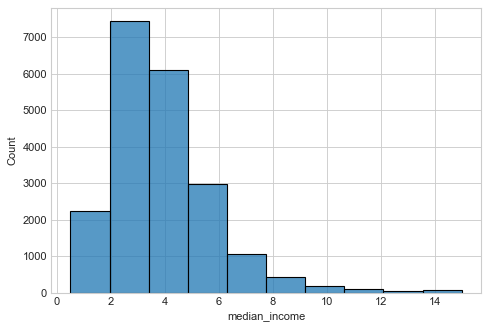

In [14]:
_, ax = plt.subplots(figsize=(6, 4), dpi=80,constrained_layout=True)

sns.histplot(data=housing, x='median_income', bins=10, ax=ax)
plt.show()

In Figure 2-8: 

* Most median income values are clustered around 1.5 to 6 (i.e., $15, 000–$60, 000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. 

* This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15, 000), category 2 from 1.5 to 3, and so on.
* However, we do not need to statify sampling every dataset, finllay we  will compare the preformance of **Sampling methods**, (e.g, Overall, Stratified and Random sampling methods), in order to determine whether we need the stratified sampling or NOT.

#### Strata sampling


In [104]:
bins_In = [0, 1.5, 3, 4.5, 6, np.inf]  # np.inf= infinity
labels_In = [1, 2, 3, 4, 5]

housing["income_categories"] = pd.cut(
    housing["median_income"], bins=bins_In, labels=labels_In
)


In [105]:
housing['income_categories'].value_counts()

3    5789
2    5265
4    2911
5    1889
1     658
Name: income_categories, dtype: int64

<AxesSubplot:>

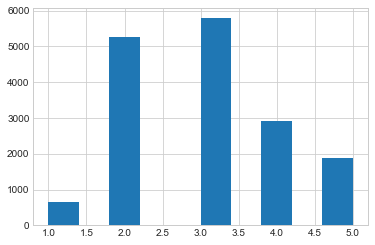

In [106]:
housing['income_categories'].hist()

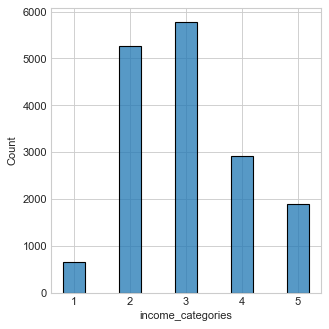

In [107]:
_, ax = plt.subplots(figsize=(4, 4), dpi=80, constrained_layout=True)

sns.histplot(housing["income_categories"], bins=10, shrink=0.4, ax=ax)
plt.show()


#### Go on stratified sampling with StratifiedShuffleSplit


In [108]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing,
                                           housing["income_categories"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

KeyError: '[7850, 14198, 13696, 5814, 280, 15939, 10442, 7129, 2620, 4402, 10223, 8847, 8359, 8644, 628, 4590, 6502, 2391, 3614, 4106, 13122, 14625, 16066, 12375, 13009, 12255, 2779, 10238, 7100, 16016, 11051, 185, 8540, 8680, 9300, 14455, 16307, 10995, 6425, 1418, 9685, 6400, 8520, 14218, 2609, 16009, 13506, 1593, 1721, 10153, 2843, 11166, 7799, 16030, 15713, 12825, 11466, 5674, 16074, 8077, 33, 3492, 3066, 11679, 13471, 6669, 6420, 6517, 5591, 13148, 11651, 10671, 10879, 11311, 5395, 8098, 11423, 15647, 3726, 10834, 9320, 15007, 10486, 758, 4964, 9445, 518, 7683, 11807, 4539, 10600, 1045, 8678, 6221, 14850, 14020, 14704, 4264, 13841, 10884, 6300, 14425, 15156, 2597, 804, 2468, 247, 6619, 9680, 15950, 886, 6043, 7894, 8016, 9282, 11353, 7022, 1166, 11178, 1596, 2554, 1750, 10005, 11115, 3314, 16459, 7916, 14555, 3952, 227, 9043, 96, 9914, 832, 13749, 8646, 14047, 15310, 6933, 15098, 159, 3719, 2614, 11591, 2428, 15795, 14992, 3360, 13690, 16127, 13586, 3180, 2549, 12951, 1926, 1168, 8033, 3747, 6589, 15392, 4851, 3381, 3265, 4785, 12736, 16316, 15650, 610, 11316, 8846, 14155, 9216, 10526, 3462, 5568, 8757, 8821, 9024, 11643, 8593, 2510, 11531, 396, 15867, 8710, 1839, 16292, 6500, 6693, 15958, 3891, 10111, 3040, 14668, 12800, 11915, 11286, 14757, 7806, 11265, 10161, 12737, 1263, 13837, 10702, 8402, 11640, 11966, 1228, 11122, 3138, 8516, 7781, 16323, 1011, 6172, 16230, 3655, 11717, 7897, 14261, 13509, 2925, 4858, 4178, 10064, 1982, 2893, 4596, 5841, 7601, 8573, 16450, 7709, 2928, 6755, 1766, 7994, 12363, 11096, 7815, 3859, 15140, 12650, 5884, 10331, 15368, 12721, 14122, 10821, 11894, 6745, 5871, 5178, 11102, 2093, 5913, 10300, 10314, 6599, 9684, 4728, 13985, 7073, 523, 11570, 11049, 8034, 6026, 5559, 374, 2523, 14158, 8060, 10926, 4263, 9663, 8489, 7736, 9504, 1694, 15382, 14961, 15801, 10737, 15833, 4119, 15328, 1469, 9233, 13309, 7317, 3995, 943, 334, 13889, 5498, 6178, 10786, 1837, 1159, 6815, 11406, 4843, 14209, 6701, 6459, 11397, 14522, 5350, 12623, 6277, 14345, 6775, 2349, 1025, 11250, 7800, 12090, 9934, 4936, 6162, 3622, 9773, 6729, 15009, 8742, 2471, 4376, 15752, 11978, 14068, 491, 7180, 5051, 951, 15482, 638, 15821, 4117, 15092, 10018, 3403, 12596, 9782, 1870, 13466, 16100, 51, 5617, 2740, 2342, 2475, 7510, 9878, 1924, 15281, 1724, 4367, 9101, 3947, 9598, 86, 3190, 10430, 14887, 15030, 15394, 817, 4960, 8508, 1941, 14367, 6964, 1218, 11639, 3730, 13851, 8683, 575, 10492, 913, 6679, 8311, 9405, 6156, 13853, 13234, 1075, 2445, 10118, 6824, 534, 14547, 14401, 8280, 9846, 9498, 15224, 13751, 9896, 4841, 4655, 10682, 4303, 12682, 14338, 15190, 13402, 15863, 13353, 7824, 11332, 13661, 6760, 7273, 2544, 14118, 11145, 3906, 11458, 2463, 12448, 4168, 5248, 7852, 3193, 10336, 6187, 9079, 14705, 3257, 13825, 11736, 1833, 4092, 15211, 14519, 1736, 6303, 8208, 1012, 15075, 10672, 7381, 3075, 4404, 9824, 10119, 3409, 13655, 11782, 5304, 4608, 4871, 5809, 9847, 2745, 5493, 12837, 10831, 13624, 2784, 11373, 15122, 4905, 5123, 6914, 10220, 15162, 12379, 13928, 5140, 4763, 3912, 10299, 16006, 15714, 6261, 1044, 7038, 11554, 5180, 4491, 11045, 13449, 15052, 15458, 15279, 5040, 7264, 13504, 2509, 3240, 157, 13774, 3324, 235, 2552, 10154, 2083, 3208, 3933, 6749, 15763, 9273, 11621, 3232, 8621, 6890, 3507, 11567, 4514, 11154, 3899, 3142, 15332, 6325, 3591, 10216, 8654, 1279, 12142, 12055, 7664, 1802, 8859, 13383, 5160, 4351, 4199, 15970, 4700, 16179, 14733, 13524, 6018, 15659, 1580, 4931, 8164, 5473, 286, 15723, 1636, 8981, 14679, 12204, 8086, 11333, 1637, 7057, 8188, 26, 3653, 4229, 1197, 2491, 765, 12008, 12723, 10377, 14954, 6184, 15770, 11298, 5139, 3209, 3260, 650, 12704, 287, 16294, 12456, 3837, 4100, 7960, 14073, 10527, 10458, 8494, 8610, 10278, 732, 10382, 3294, 6349, 9283, 5950, 9644, 11739, 12338, 4503, 3846, 603, 9349, 9837, 182, 16383, 14260, 14404, 15264, 7409, 1091, 1787, 6690, 4986, 11208, 3921, 10697, 5241, 4722, 10473, 530, 645, 9053, 11620, 1193, 6746, 6159, 2433, 8272, 4504, 11888, 9425, 13492, 14553, 10866, 13493, 9886, 8901, 512, 8509, 5986, 4941, 16310, 3950, 9260, 5859, 9546, 5985, 12589, 15748, 14860, 4976, 13067, 5502, 5671, 9618, 10557, 4285, 16236, 3325, 15769, 14649, 2770, 3925, 5961, 2261, 1256, 16456, 7521, 6695, 14575, 14841, 7500, 10630, 8765, 15245, 7310, 6489, 1005, 13954, 9188, 10818, 4457, 10416, 6595, 13794, 9675, 2484, 13539, 10380, 10011, 9236, 114, 10593, 10347, 5700, 10010, 10021, 15785, 15662, 16407, 3536, 1026, 2005, 7519, 5793, 39, 9206, 13975, 2751, 9372, 13404, 16442, 10129, 2865, 10403, 7457, 7468, 8496, 1684, 10217, 7760, 3658, 10146, 5285, 728, 9883, 4699, 13431, 5800, 9239, 14281, 1715, 8314, 8262, 12073, 707, 4550, 4157, 8785, 10840, 8602, 6343, 14937, 1361, 1452, 6365, 7584, 12599, 12642, 11319, 11438, 8510, 11338, 3911, 13163, 12569, 12912, 14529, 10421, 502, 4233, 1352, 3603, 10620, 12152, 730, 5428, 301, 15073, 12019, 13584, 12318, 3200, 14392, 14294, 7272, 6231, 2106, 8993, 9306, 5062, 9866, 8210, 3861, 10511, 7622, 8389, 2518, 4601, 12565, 9908, 15634, 13192, 5488, 3328, 1207, 4644, 3160, 9836, 2321, 6294, 8201, 10806, 10008, 11667, 657, 15131, 4498, 10528, 619, 9756, 11093, 6591, 8243, 8957, 11106, 397, 6810, 731, 10285, 8658, 5566, 10980, 14451, 7608, 13683, 13107, 14412, 11179, 971, 12734, 1398, 1739, 4369, 4452, 9428, 263, 9004, 14336, 8103, 6721, 5818, 8574, 9035, 4641, 12698, 16195, 2286, 14437, 5705, 10226, 11039, 5388, 4882, 3816, 9395, 3780, 1084, 8616, 6021, 10778, 3270, 2447, 7681, 12302, 1327, 761, 6902, 15663, 11623, 8348, 16239, 1952, 2327, 13550, 11924, 799, 12171, 2202, 2225, 6862, 7658, 15218, 9746, 4430, 14596, 3178, 4818, 15952, 16017, 3900, 8012, 9766, 9658, 435, 8931, 6219, 16253, 11599, 15329, 3414, 14354, 448, 7006, 15652, 14252, 11238, 1180, 3727, 14830, 11047, 2739, 3772, 6077, 3519, 9605, 6949, 16208, 8041, 5593, 15646, 14651, 13729, 174, 4173, 6894, 15399, 4118, 5380, 2966, 10315, 14298, 15656, 136, 11174, 12175, 5385, 13229, 5005, 5136, 11190, 11413, 8365, 8031, 10898, 12848, 1463, 8569, 9094, 13564, 12697, 2890, 3640, 5888, 3470, 9141, 9867, 13581, 11425, 14449, 5556, 13905, 9973, 10199, 7438, 3411, 4239, 13167, 7796, 7205, 16048, 10627, 12170, 14268, 10498, 15091, 7640, 11758, 6098, 11483, 2014, 968, 16301, 11637, 14444, 6494, 9064, 13877, 16007, 9284, 2619, 3335, 13097, 13116, 6160, 4532, 12999, 8101, 6942, 13531, 15764, 4427, 4280, 9218, 11895, 2569, 13951, 720, 3229, 4939, 1702, 7032, 10730, 13062, 5506, 3091, 14671, 12137, 2605, 15908, 2130, 7458, 7152, 3509, 3822, 15498, 7093, 3502, 11542, 7479, 5238, 8715, 6957, 1034, 4796, 9996, 1076, 455, 2147, 7419, 1539, 5892, 7944, 7750, 12516, 2283, 1657, 16112, 1341, 984, 1940, 1668, 13712, 6965, 8538, 4990, 13332, 15684, 1643, 15864, 9014, 8265, 10450, 13959, 12634, 5321, 1000, 13587, 14972, 3484, 7348, 6022, 8418, 8530, 15552, 15536, 9026, 9025, 10717, 10149, 6945, 11721, 1765, 10100, 15067, 1662, 5988, 10970, 2152, 5340, 8768, 9930, 3949, 8399, 11695, 7678, 14384, 8442, 11781, 1673, 3845, 11196, 12384, 8196, 14481, 13227, 14348, 12895, 5791, 2194, 3118, 13008, 1644, 4252, 16214, 15843, 7440, 11616, 4249, 15232, 14021, 12223, 13787, 4501, 10767, 12695, 7470, 9677, 14100, 13786, 15556, 7147, 8551, 12713, 1101, 14975, 5454, 4146, 375, 3072, 14521, 73, 6186, 7303, 12072, 1239, 6355, 8736, 6447, 16263, 1635, 13606, 2105, 10871, 8591, 5899, 13802, 13198, 12465, 14560, 9293, 3198, 9325, 14644, 12467, 9075, 6131, 12003, 11007, 3696, 4991, 8688, 4302, 2699, 8168, 12036, 14389, 16054, 735, 13705, 13555, 9305, 6321, 8069, 23, 2855, 14846, 12185, 8114, 3018, 2526, 7794, 8979, 11930, 12896, 9619, 16420, 9231, 12769, 8345, 1224, 13618, 4962, 9686, 5784, 6901, 15825, 8398, 8027, 10951, 7276, 11086, 11346, 13079, 15196, 15797, 16380, 10674, 8561, 3359, 15741, 15642, 8285, 12337, 10469, 13952, 11136, 6826, 4505, 1528, 15854, 10090, 960, 9872, 2263, 12953, 2258, 13026, 2449, 12820, 2591, 13277, 11340, 9380, 6603, 10662, 12652, 11155, 7176, 684, 12678, 11147, 12010, 747, 1141, 1421, 8477, 14811, 11006, 15378, 12367, 4113, 8858, 3433, 333, 15570, 14701, 8790, 8072, 5611, 12180, 9191, 9585, 17, 4618, 3936, 6907, 13829, 13145, 2487, 15608, 14590, 1744, 1295, 13228, 14612, 9743, 1419, 12461, 6289, 12209, 4881, 1108, 2735, 12701, 12968, 5984, 4300, 900, 9526, 12017, 3812, 4122, 756, 6849, 3275, 7998, 4299, 7357, 13906, 9597, 5152, 12271, 16258, 7324, 8429, 11419, 13806, 5072, 15070, 11222, 7190, 161, 8014, 11447, 15772, 10986, 5187, 7355, 13142, 7745, 3843, 6450, 1947, 12810, 2446, 3485, 9780, 1811, 3518, 2979, 5313, 15215, 316, 9848, 4286, 891, 14307, 5928, 7529, 13502, 9733, 15241, 6360, 13395, 11247, 2633, 3755, 13497, 1304, 2753, 14, 854, 6302, 10245, 4996, 15379, 10396, 7928, 10990, 13916, 5812, 15331, 14711, 5628, 14957, 6702, 5276, 12182, 6913, 1021, 1538, 4439, 13754, 12989, 7465, 4033, 10072, 11642, 1688, 3330, 13804, 9468, 10024, 3529, 1482, 84, 3753, 12824, 4331, 12388, 5077, 10943, 5807, 14405, 7145, 6687, 8317, 5175, 16212, 2461, 13164, 15209, 8219, 10533, 3587, 3120, 5376, 9459, 9616, 2252, 10714, 4942, 8367, 2513, 7431, 4750, 1037, 8354, 4614, 3840, 953, 7494, 7739, 9089, 6188, 10030, 12510, 641, 11843, 14490, 6483, 9532, 6038, 9648, 14479, 4310, 15200, 13260, 4038, 3173, 4443, 14566, 4248, 1556, 13311, 306, 4935, 7390, 7582, 2592, 941, 1502, 3893, 14274, 8532, 5876, 15443, 15366, 14035, 12496, 2028, 13943, 1719, 2540, 5754, 7889, 4429, 4243, 3692, 3189, 5547, 13570, 13927, 1549, 14190, 16238, 8894, 5371, 2291, 5887, 3882, 1261, 11523, 4366, 12762, 8289, 16237, 6863, 11944, 2089, 11571, 1158, 4657, 5879, 1619, 1630, 1018, 14524, 207, 9489, 3158, 13023, 4083, 8089, 10742, 13510, 13390, 13917, 14943, 14179, 11508, 9995, 10428, 11449, 6785, 3375, 2110, 7448, 3056, 6175, 12117, 9721, 2851, 1316, 7532, 12666, 15047, 13580, 13842, 7898, 12362, 11042, 2743, 13279, 11766, 3252, 6398, 16403, 8977, 6412, 62, 10434, 4181, 2635, 14388, 11287, 8002, 10332, 9358, 16076, 75, 3398, 16415, 8107, 1838, 15243, 5096, 7282, 6794, 4953, 16458, 15489, 8304, 6417, 15, 5481, 1706, 14301, 13636, 8185, 8924, 3663, 3844, 12941, 8546, 1901, 9735, 2817, 3740, 7568, 8254, 12149, 12578, 10418, 3602, 1494, 3676, 13270, 12089, 4191, 1704, 10099, 8163, 13117, 6488, 5358, 5117, 10581, 8316, 11098, 2204, 15722, 5355, 12994, 8904, 16299, 662, 5858, 12793, 11065, 16423, 9634, 15226, 5472, 8230, 13582, 10489, 7598, 10963, 5620, 8684, 16295, 1476, 367, 7516, 14564, 3183, 5677, 9768, 14697, 1960, 14044, 10621, 3115, 11044, 14635, 918, 8645, 7428, 1980, 13223, 13494, 4599, 15406, 4569, 11524, 905, 54, 750, 7825, 14488, 10068, 13589, 5840, 4253, 9353, 7880, 3965, 5867, 9000, 532, 3904, 11728, 13597, 13960, 14201, 15780, 5936, 4148, 14175, 16302, 15039, 1048, 12222, 10665, 2494, 5415, 7238, 9763, 7958, 9946, 16140, 3620, 14931, 12677, 11097, 4921, 14002, 7541, 14284, 13082, 15169, 8773, 8109, 4103, 13507, 6645, 15526, 4712, 13039, 6054, 7513, 7656, 4431, 14787, 12616, 1155, 11649, 3114, 10554, 16155, 7235, 11685, 3815, 2297, 13991, 10967, 15909, 15519, 5734, 5239, 13436, 11801, 5750, 10977, 7497, 1275, 11272, 3561, 8111, 576, 2789, 1773, 10989, 143, 4091, 5134, 4772, 5680, 10542, 6113, 9332, 14099, 5451, 14306, 14331, 4228, 16487, 3238, 5035, 7812, 11121, 11076, 8507, 7342, 13647, 4513, 2565, 10815, 12351, 6960, 6308, 15203, 11603, 792, 5420, 15677, 2053, 11300, 12841, 15692, 5992, 4929, 5287, 9989, 12205, 13875, 7974, 5353, 1653, 12249, 12958, 11108, 6758, 101, 13501, 15194, 14010, 11982, 10070, 4169, 11977, 5878, 9781, 16371, 3721, 867, 1972, 7156, 14066, 5212, 15038, 10942, 2134, 8067, 13541, 10909, 14567, 9845, 8952, 5217, 9432, 13, 14592, 8204, 9022, 6315, 16210, 4955, 2975, 8239, 6672, 11836, 1302, 2511, 9641, 16265, 16332, 4933, 7240, 15183, 16250, 9019, 13478, 9279, 7248, 5086, 694, 3137, 10881, 12964, 12455, 16498, 8913, 3126, 6348, 15828, 16474, 1781, 517, 10046, 3619, 4731, 4544, 5898, 2584, 4262, 11186, 4844, 5284, 8734, 9021, 6373, 13735, 2125, 4564, 9437, 16149, 2712, 5011, 12432, 6479, 7089, 6854, 15529, 12867, 5550, 726, 7405, 7593, 12773, 12111, 16145, 15064, 6888, 6478, 8835, 13633, 11859, 2839, 2264, 4854, 2240, 6073, 14167, 12833, 10066, 7954, 8264, 2347, 13343, 6058, 9525, 12045, 16178, 8854, 6136, 15675, 8275, 10270, 2834, 14096, 15643, 13476, 2607, 10391, 5065, 5379, 11755, 1145, 9933, 543, 7114, 2379, 6465, 5924, 12371, 11342, 1061, 13779, 8142, 15943, 3067, 4870, 936, 7241, 11821, 6946, 4977, 3340, 13892, 14422, 4922, 15899, 12638, 9885, 15354, 5636, 1298, 16092, 14773, 11137, 771, 13380, 9516, 10184, 12310, 2246, 10582, 15182, 9494, 7439, 3554, 3897, 15237, 13219, 12813, 92, 12101, 7326, 15865, 14793, 4396, 4014, 10310, 8180, 1041, 6110, 3074, 3011, 10483, 1134, 5039, 15453, 12600, 10039, 5499, 12042, 11195, 7984, 13289, 1489, 13583, 7394, 465, 8385, 3697, 14959, 12248, 9472, 6191, 1541, 7012, 5078, 2586, 9637, 4570, 3464, 16377, 1521, 9385, 12144, 13204, 6106, 15491, 8823, 4951, 13490, 11088, 14120, 15066, 13125, 3009, 9713, 9820, 5094, 10109, 4804, 6296, 970, 6347, 409, 5437, 14265, 9786, 9147, 8650, 4131, 9823, 13894, 5000, 14199, 3097, 7094, 10116, 6341, 3520, 10798, 2318, 9659, 4652, 7312, 310, 3082, 5389, 4001, 11142, 11753, 6553, 9508, 2339, 3513, 2213, 8884, 7623, 16134, 5614, 9876, 2876, 15688, 3877, 343, 5296, 13382, 8606, 7236, 2503, 15911, 704, 13432, 2373, 7207, 4767, 12407, 3175, 4660, 9386, 14692, 16060, 9521, 5832, 10094, 9013, 11536, 3521, 998, 10086, 15125, 652, 14971, 4240, 1994, 13087, 6124, 6997, 10573, 2443, 4030, 3560, 7755, 14842, 15590, 993, 6493, 7673, 167, 11310, 13446, 15490, 2398, 2530, 7626, 781, 5583, 7999, 7662, 4776, 10383, 15478, 3768, 14667, 2671, 13981, 10692, 13734, 12268, 15433, 11156, 5387, 5966, 10191, 8080, 896, 4588, 2049, 12795, 14685, 946, 14363, 4267, 8451, 1007, 12717, 1450, 5108, 13417, 11663, 2168, 6180, 15671, 318, 5916, 10998, 13243, 8502, 14867, 8560, 2146, 2166, 4697, 6983, 10769, 8519, 6691, 14370, 10902, 1705, 5210, 4144, 12320, 13716, 11876, 13557, 6748, 12416, 15473, 7314, 248, 5819, 2249, 4046, 12850, 8919, 8782, 7269, 4545, 15123, 1983, 4757, 16182, 3581, 8587, 14924, 5909, 16444, 4686, 16029, 2262, 14765, 466, 15191, 1783, 4135, 10108, 16111, 653, 16013, 7157, 14312, 12107, 10097, 14189, 13081, 1730, 1420, 7245, 6312, 3866, 3685, 12373, 6779, 1010, 9262, 2024, 8949, 6941, 11670, 6838, 12802, 5787, 8793, 15881, 2278, 16065, 7485, 6527, 1072, 4989, 3748, 12105, 14989, 5091, 4948, 15919, 12106, 6604, 7043, 6733, 10927, 1819, 5436, 14027, 4803, 4105, 8428, 8038, 14511, 480, 9764, 8495, 14217, 11301, 10623, 2884, 11797, 12359, 12846, 1923, 1978, 8426, 16387, 6827, 4944, 5933, 11426, 2933, 801, 1253, 1796, 13394, 387, 12610, 546, 1910, 10914, 7489, 13832, 6770, 10507, 15201, 12160, 8043, 9997, 8220, 3251, 5504, 7275, 674, 79, 9528, 1164, 2292, 14808, 3668, 11037, 2935, 8607, 3291, 16097, 4283, 3219, 4788, 12485, 6331, 14801, 8125, 8146, 11422, 14057, 4197, 8759, 8708, 3715, 12594, 5332, 7740, 2697, 15303, 10534, 4081, 9220, 5126, 8781, 116, 11672, 12450, 7415, 3055, 10669, 1996, 3476, 2940, 4042, 16148, 11075, 15755, 283, 13177, 2848, 9471, 14052, 3767, 9880, 6196, 10151, 14476, 5761, 125, 9784, 6484, 10530, 851, 15879, 11564, 4687, 10105, 6928, 11354, 2682, 4520, 10561, 10579, 12745, 1320, 14690, 14495, 13702, 16276, 7432, 6909, 15262, 11467, 10651, 3323, 12261, 13929, 10569, 3588, 12184, 2870, 9337, 15274, 9765, 9515, 10490, 9132, 11539, 5803, 11909, 14485, 13111, 13684, 15523, 13461, 14950, 8598, 7646, 9001, 10054, 15301, 14515, 13945, 15046, 7579, 10256, 1122, 6596, 7050, 6260, 22, 470, 16023, 6845, 4067, 12726, 10125, 443, 4359, 2325, 4104, 8076, 15534, 2787, 1110, 3084, 3628, 2186, 15086, 8449, 12945, 2077, 9719, 9714, 6796, 6743, 5372, 4141, 13036, 14239, 6605, 1428, 4878, 10625, 3385, 2541, 14140, 14061, 5464, 11352, 4309, 6281, 15288, 4642, 15000, 1935, 8217, 12174, 12259, 1121, 11053, 1498, 4994, 7340, 7292, 3152, 1503, 3589, 2199, 14296, 10670, 15657, 5983, 399, 9923, 14646, 3729, 8670, 7555, 16336, 8609, 9693, 3165, 126, 10641, 12665, 13528, 37, 10330, 12537, 13642, 3907, 8130, 1647, 5910, 2386, 9920, 11676, 1032, 11291, 14550, 9758, 497, 10615, 11624, 10320, 16304, 3701, 7150, 2829, 1182, 4877, 10468, 12376, 12333, 10254, 12424, 14978, 5059, 5230, 15868, 12311, 11113, 12218, 14110, 12206, 9157, 5374, 7810, 2539, 4487, 9612, 10180, 10655, 13561, 9454, 9399, 14181, 15330, 16290, 3417, 15071, 11724, 500, 11289, 10201, 6310, 14778, 8376, 2281, 5764, 3967, 12296, 2097, 7648, 2709, 6313, 15015, 12360, 12756, 10368, 6472, 753, 7161, 928, 15878, 12213, 4426, 5397, 2860, 5225, 1081, 3092, 15933, 1829, 4149, 12544, 2974, 8019, 8620, 6322, 2363, 8454, 6951, 3210, 10839, 3212, 5261, 14417, 7142, 6211, 976, 11551, 3428, 13707, 13657, 4678, 6920, 16073, 12555, 9517, 9574, 16413, 9806, 15666, 9375, 12047, 1656, 14756, 6683, 11312, 7192, 11282, 2492, 12033] not in index'

In [109]:
# Compare the stratify sampling with the overall sampling

# strat_test_set['income_categories'].value_counts() / len(strat_test_set)
# housing['income_categories'].value_counts() / len(housing)

# Of course we can make a dataframe
# to compare all the three sampling methods:

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

mthds = ['Overall','Stratified','Random']
dfs = [housing,strat_test_set,test_set]

compare_props = []

for i in range(3):
    incom_cat_props = dfs[i]["income_categories"].value_counts() / len(dfs[i])
    compare_props.append(incom_cat_props)

compare_props = pd.DataFrame(compare_props).T.set_axis(mthds, axis=1, inplace=False)

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
3,0.350594,0.350533,0.356343,1.639851,-0.017274
2,0.318859,0.318798,0.315168,-1.157559,-0.018993
4,0.176296,0.176357,0.174992,-0.739436,0.034352
5,0.114402,0.114583,0.114441,0.034763,0.158814
1,0.039850,0.039729,0.039055,-1.993490,-0.303951


As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed.


#### We spent quite a bit of time on test set generation **for a good reason**:

 - This is an often neglected but ritical part of a Machine Learning project. 
 
- Moreover, many of these ideas will be useful later when we discuss crossvalidation. 

## Discover and Visualize the Data to Gain Insights


If the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. 

In our case, the set is quite small, so you can just work directly on the full set. Let’s create a copy so that you can play with it without harming the training set:

In [110]:
housing = strat_train_set.copy()

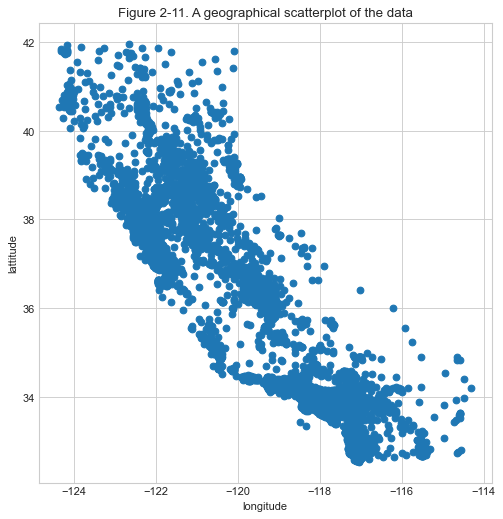

In [111]:
_, ax = plt.subplots(figsize=(6,6), dpi=80, constrained_layout=True)

ax.scatter(data=housing, x="longitude", y="latitude")
plt.savefig('./img/2.11_bad_visualization_plot.png')
ax.set(xlabel='longitude',ylabel='lattitude',
       title="Figure 2-11. A geographical scatterplot of the data")
plt.show()

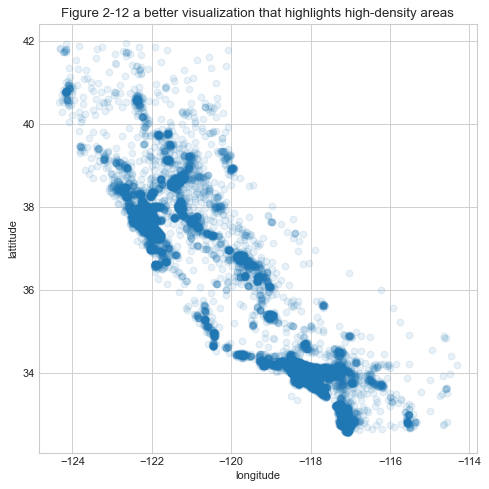

In [112]:
_, ax = plt.subplots(figsize=(6, 6), dpi=80, constrained_layout=True)

ax.scatter(data=housing, x="longitude", y="latitude",alpha = 0.1)
ax.set(xlabel='longitude',ylabel='lattitude',
       title='Figure 2-12 a better visualization that highlights high-density areas')
plt.savefig('./img/2.12_better_visualization_plot.png')
plt.show()

Now that’s much better: you can clearly see the high-density areas.

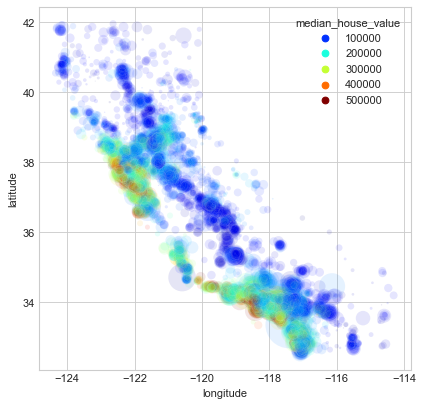

In [113]:
_, ax = plt.subplots(figsize=(6, 6), dpi=80)

sns.set_context(font_scale=2)

g = sns.scatterplot(data=housing, 
                    x="longitude", y="latitude",
                   alpha=0.1,ax=ax,
                   hue="median_house_value",#for colors below
                    s=housing["population"] / 20,
                    palette=plt.get_cmap("jet"))
plt.savefig('./img/2.12.5_better_colors_visualization_plot.png')
plt.show()

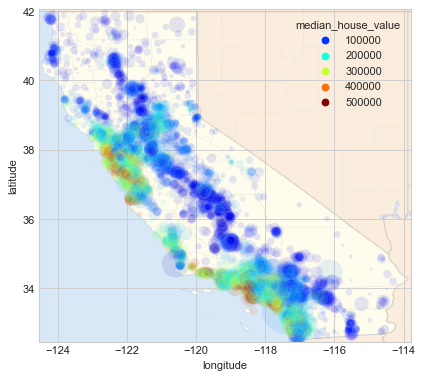

In [114]:
# Now intro Cali map jpeg
import matplotlib.image as mpimg

california_img = mpimg.imread('./img/california.png')

_, ax = plt.subplots(figsize=(6,6), dpi=80)

sns.set_context(font_scale=2)

g = sns.scatterplot(data=housing, 
                    x="longitude", y="latitude",
                   alpha=0.1,ax=ax,
                   hue="median_house_value",#for colors below
                    s=housing["population"] / 20,
                    palette=plt.get_cmap("jet"))

# Now for cal map:
ax.imshow(california_img,alpha=0.4,
          extent=[-124.55, -113.80, 32.45, 42.05],
          cmap=plt.get_cmap("jet")
         )
plt.savefig('./img/2.13_Cali_housing_prices.png')
plt.show()

## Looking for Correlations

Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method

In [115]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [116]:
midHval = corr_matrix["median_house_value"].sort_values(ascending=False)

In [117]:
attrs = midHval.index[0:4]
attrs

Index(['median_house_value', 'median_income', 'total_rooms',
       'housing_median_age'],
      dtype='object')

Now we can see there are correlations among:

    median_house_value    1.000000
    median_income         0.687160
    total_rooms           0.135097
    housing_median_age    0.114110

So plot a corr matrix by sns:

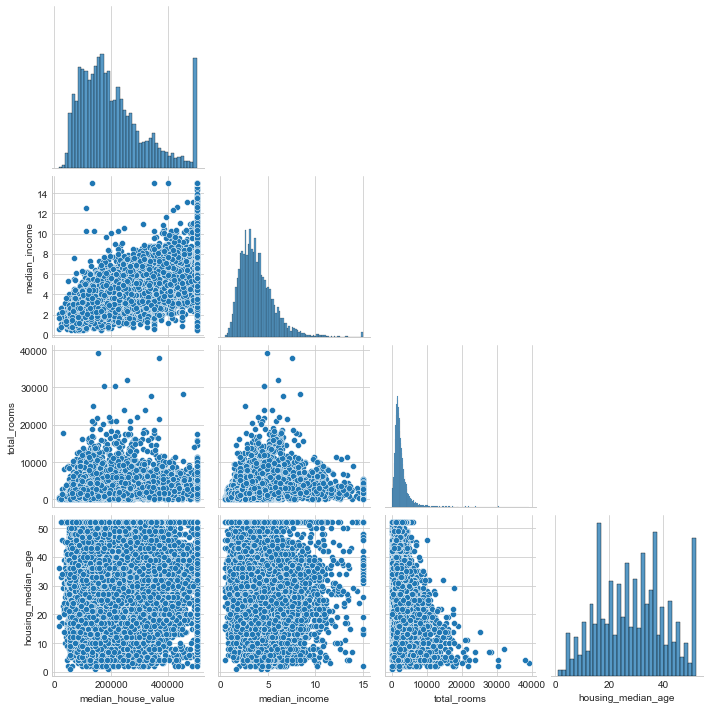

In [118]:

g = sns.pairplot(housing[attrs],
                 corner=True)

plt.show()
# very slow take it easy

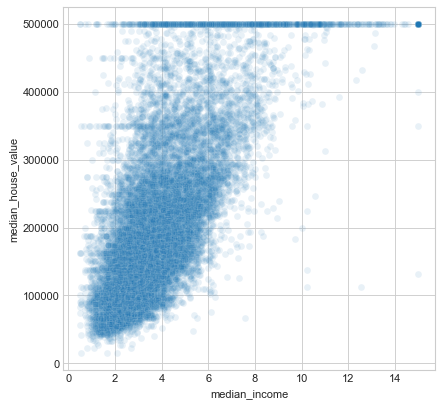

In [119]:
_, ax = plt.subplots(figsize=(6, 6), dpi=80)

g = sns.scatterplot(data=housing, 
                   x="median_income", y="median_house_value",
                   alpha=0.1,ax=ax)
plt.show()

This plot reveals a few things:

- First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. 

- Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. 

- **However, This plot reveals other less obvious straight lines**: 

a horizontal line around 450,000 dollars, another around 350,000 dollars perhaps one around $280,000, and a few more below that.

**You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.**


### Dataprep library

In [120]:
from dataprep import eda

In [121]:
# check missing values
housing.isnull().mean() 

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.009569
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
income_categories     0.000000
dtype: float64

  0%|                                                   | 0/153 [00:00<?, ?it/s]


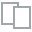
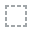
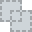
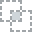
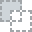
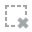
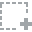
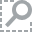
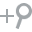
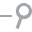
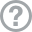
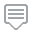
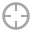
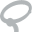
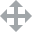
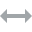
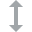
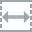
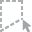
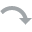
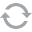
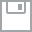
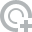
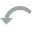
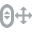
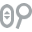
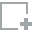
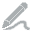
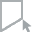
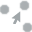
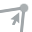
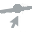

In [122]:
eda.plot_missing(housing)

100%|#####################################################| 4/4 [00:00<?, ?it/s]


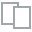
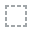
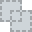
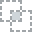
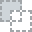
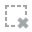
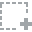
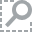
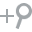
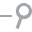
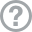
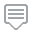
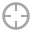
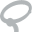
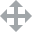
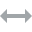
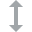
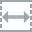
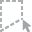
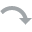
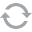
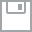
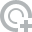
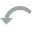
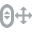
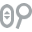
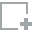
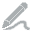
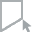
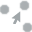
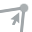
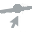

In [123]:
# correlation plot:
eda.plot_correlation(housing)

In [124]:
housing_corr = housing.corr()
housing_corr["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [125]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_categories
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3


In [126]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing[
    "bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing[
    "population_per_household"] = housing["population"] / housing["households"]

In [127]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_categories,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3,4.505810,0.231341,3.047847


In [128]:
housing_corr = housing.corr()# new features
housing_corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.028345,0.095603,-0.000410
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,0.107621,-0.116884,0.005420
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.147186,0.136788,0.015031
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.127519,-0.192606,-0.024810
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.000377,0.086960,-0.028370
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,-0.074692,0.037778,0.076225
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,-0.083009,0.067162,-0.027416
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.311563,-0.624674,0.021822
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.146285,-0.259984,-0.021985
rooms_per_household,-0.028345,0.107621,-0.147186,0.127519,0.000377,-0.074692,-0.083009,0.311563,0.146285,1.000000,-0.398546,-0.005314


In [129]:
housing_corr["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [130]:
housing.columns[-3:]

Index(['rooms_per_household', 'bedrooms_per_room', 'population_per_household'], dtype='object')

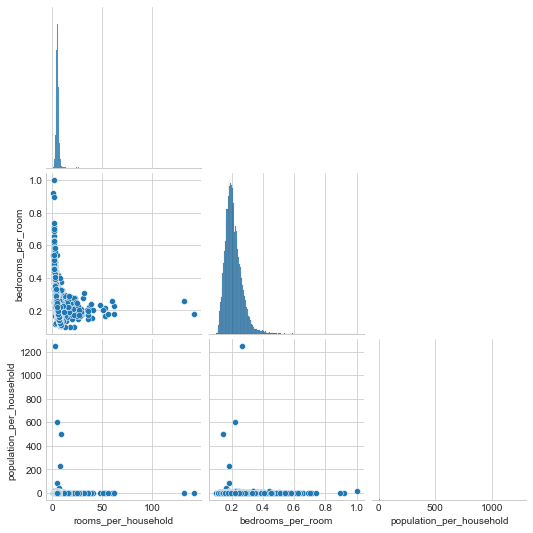

In [131]:
attrs_per = housing.columns[-3:]

g = sns.pairplot(housing[attrs_per],corner=True)

In [132]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


## Prepare the data for Machine Learning algorithms

### Revert to a clean training set (by copying strat_train_set once again).

In [133]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Data Cleaning Most Machine Learning algorithms cannot work with missing features。 We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

1. Get rid of the corresponding districts.
    - housing.dropna(subset=["total_bedrooms"])    `# option 1` 
2. Get rid of the whole attribute.
    - housing.drop("total_bedrooms", axis=1)       `# option 2`
3. Set the values to some value (zero, the mean, the median, etc.).
      - median = housing["total_bedrooms"].median()   `# option 3` 
      - housing["total_bedrooms"].fillna(median, inplace=True)

In [134]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]

In [135]:
sample_incomplete_rows.shape

(158, 10)

In [136]:
sample_incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_categories
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3


In [137]:
# total_bedrooms = nan, drop
# option 1:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_categories


In [138]:
sample_incomplete_rows.shape

(158, 10)

In [139]:
sample_incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_categories
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3


In [140]:
# option 2
sample_incomplete_rows.drop("total_bedrooms",axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_categories
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...
3376,-118.28,34.25,29.0,2559.0,1886.0,769.0,2.6036,<1H OCEAN,2
4691,-118.37,34.07,50.0,2519.0,1117.0,516.0,4.3667,<1H OCEAN,3
6052,-117.76,34.04,34.0,1914.0,1564.0,328.0,2.8347,INLAND,2
17198,-119.75,34.45,6.0,2864.0,1404.0,603.0,5.5073,NEAR OCEAN,4


In [141]:
#option 3
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [142]:
sample_incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_categories
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN,2
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN,4
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN,4
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND,2
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN,3


Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`:

In [143]:
from sklearn.impute import SimpleImputer

# create a SimpleImputer instance, 
# specifying that you want to replace each attribute’s missing values 
# with the median of that attribute:

imputer = SimpleImputer(strategy="median")

In [144]:
# Since the median can only be computed on numerical attributes, 
# you need to create a copy of the data.
# without the text attribute ocean_proximity:

housing_num = housing.drop("ocean_proximity",axis=1)

In [145]:
# fit the imputer instance to the training data using the fit() method
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [146]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [147]:
housing_num.median().values

/var/folders/1q/m8l_wvxd5dl8kccgv4xrsxtr0000gn/T/ipykernel_88539/3605723347.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  housing_num.median().values


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

`imputer.statistics_` and `housing_num.median().values` are equal right?
Ok, what is the replacing method again? Try `strategy`

In [148]:
imputer.strategy

'median'

Use this “trained” imputer to transform the training set **by replacing missing values with the learned medians**:

In [149]:
X = imputer.transform(housing_num)

In [150]:
housing_tr = pd.DataFrame(X,
                          columns=housing_num.columns,
                          index=housing_num.index)

In [151]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_categories
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,3.0


In [152]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_categories
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,2.0
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,4.0
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,4.0
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,2.0
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,3.0
...,...,...,...,...,...,...,...,...,...
3376,-118.28,34.25,29.0,2559.0,433.0,1886.0,769.0,2.6036,2.0
4691,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667,3.0
6052,-117.76,34.04,34.0,1914.0,433.0,1564.0,328.0,2.8347,2.0
17198,-119.75,34.45,6.0,2864.0,433.0,1404.0,603.0,5.5073,4.0


Issue:Why there is a "income_categories" col which is absent from the original code?
so get rid of this column firstly.




In [153]:
housing_tr = housing_tr.drop("income_categories",axis=1)


In [154]:
housing_tr.shape

(16512, 8)

### Handling Text and Categorical Attributes

In [155]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [156]:
housing_cat.value_counts()
# woo~~~ somebody bought islands!

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

In [157]:
from sklearn.preprocessing import OrdinalEncoder


Convert these categories from text to numbers. For this, we can use Scikit-Learn’s `OrdinalEncoder`

In [158]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [159]:
ordinal_encoder.categories_
# I like the housing_cat.value_counts()

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### OneHotEncoder

In [160]:
from sklearn.preprocessing import OneHotEncoder

Create one binary attribute per category with on-hot encoding,by`OneHotEncoder`

In [161]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [162]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [163]:
col_1hot = cat_encoder.categories_

ALso we can [convert the sparse matrix to a pd.DataFrame:](https://stackoverflow.com/questions/59339820/convert-a-numpy-float64-sparse-matrix-to-a-pandas-data-frame)

In [164]:
hotdf = pd.DataFrame(housing_cat_1hot.toarray(),columns=col_1hot)
hotdf.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [165]:
# also again, dummmies help us:
pd.get_dummies(housing_cat).head(15)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,1,0,0,0,0
18632,1,0,0,0,0
14650,0,0,0,0,1
3230,0,1,0,0,0
3555,1,0,0,0,0
19480,0,1,0,0,0
8879,1,0,0,0,0
13685,0,1,0,0,0
4937,1,0,0,0,0
4861,1,0,0,0,0


Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [166]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [167]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Create a  **custom transformer** to add extra attributes:

Custom Transformers:

- Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn func‐tionalities (such as pipelines), and since Scikit-Learn relies on **[duck typing](https://en.wikipedia.org/wiki/Duck_typing)** (not inher‐itance), all you need to do is create a class and implement three methods: fit() (returning self), transform(), and fit_transform().


You can get the last one for free by simply adding TransformerMixin as a base class.
If you add BaseEstimator as a base class (and avoid \*args and \**kargs in your con‐structor),you will also get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning.
For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [168]:
# now remember:
housing_tr.iloc[:,3:7].head(3)
# dowbelow: rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

,total_rooms,total_bedrooms,population,households
17606,1568.0,351.0,710.0,339.0
18632,679.0,108.0,306.0,113.0
14650,1952.0,471.0,936.0,462.0


In [169]:
from sklearn.base import BaseEstimator, TransformerMixin

In [170]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__(self, add_bedrooms_per_room = True): 
        # no *args or **kargs 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None): 
        return self
        
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [171]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to **True** by default (it is often helpful to provide sensible defaults).This hyperpara‐meter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. 

More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

With this customized transformer,let's move on to the:
### Transformation Pipelines.

In [172]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [173]:
num_pipeline = Pipeline([
                    ('imputer',SimpleImputer(strategy="median")),
                    ('attribs_adder',CombinedAttributesAdder()),
                    ('std_scaler', StandardScaler()),
    
])

In [174]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [175]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

#### full_pipeline

In [176]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                        ("num_pipline", num_pipeline,num_attribs),
                        ("cat_pipeline", OneHotEncoder(),cat_attribs),
    
])

housing_prepared = full_pipeline.fit_transform(housing)

In [177]:
# just check, not for model training
pd.DataFrame(housing_prepared)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.954456,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,1.890305,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.954456,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.954456,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.006202,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.722267,-0.673331,1.379547,-0.632123,-0.725361,-0.759010,-0.764049,0.554158,0.942051,0.234352,-0.031755,-0.428853,0.0,1.0,0.0,0.0,0.0
16508,1.007011,-0.823004,0.902385,-0.667196,-0.584183,-0.329664,-0.636291,-0.948815,-0.954456,-0.308114,0.084689,0.491503,0.0,1.0,0.0,0.0,0.0
16509,1.586489,-0.724781,-1.562952,1.043901,0.822735,0.607904,0.713156,-0.316705,-0.006202,0.346934,-0.030554,-0.521776,0.0,1.0,0.0,0.0,0.0
16510,0.782213,-0.851068,0.186642,-0.309919,-0.374849,-0.057178,-0.375451,0.098121,-0.006202,0.024995,0.061509,-0.303407,1.0,0.0,0.0,0.0,0.0


In [178]:
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'income_categories']

In [179]:
cat_attribs

['ocean_proximity']

In [180]:
housing_prepared.shape

(16512, 17)

In [181]:
housing_labels.shape

(16512,)

### Select and train a model

#### LinearRegression

In [182]:
from sklearn.linear_model import LinearRegression

In [183]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [184]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print(f'Predictions: {lin_reg.predict(some_data_prepared)};\n Lables: {list(some_labels)}.')


Predictions: [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039];
 Lables: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0].


In [185]:
# check
pd.DataFrame(some_data_prepared)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.954456,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,1.890305,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.954456,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.954456,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.006202,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0


Let’s measure this regression model’s RMSE on the whole training set using `ScikitLearn’s mean_squared_error()` function:

In [186]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [187]:
housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_mae = mean_absolute_error(housing_labels,housing_predictions)

lin_r2 = r2_score(housing_labels,housing_predictions)

print(f'With Linear Regression Model,\
The Root Mean Squared Error is {lin_rmse},\
\nThe Mean Absolute Error is {lin_mae},\
\nThe R2 Score is {lin_r2}') 

NameError: name 'r2_score' is not defined

This is an example of a model **underfitting** the training data.

#### DecisionTreeRegression

Here comes the `DecisionTreeRegressor` models:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_mae = mean_absolute_error(housing_labels,housing_predictions)

tree_r2 = r2_score(housing_labels,housing_predictions)

print(f'With the Decision Tree Regression Model,\
The Root Mean Squared Error is {tree_rmse},\
\nThe Mean Absolute Error is {tree_mae},\
\nThe R2 Score is {tree_r2}') 

In [ ]:
# 0.0....just like a nerd looking at you, this is an overfit case.

##### Better Evaluation Using Cross-Validation

In [ ]:
# Scikit-Learn’s K-fold cross-validation feature
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,
                         scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
# book method:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

In [ ]:
# Or:
print(f'Scores:{tree_rmse_scores},\
\n Mean:{tree_rmse_scores.mean()},\
\n Standard deviation: {tree_rmse_scores.std()}')

Compute the same scores for the Linear Regression model

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared,housing_labels,
                            scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

#### RandomForestRegression

Compute the same scores for `RandomForestRegressor`

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels,housing_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_mae = mean_absolute_error(housing_labels,housing_predictions)

forest_r2 = r2_score(housing_labels,housing_predictions)

print(f'With the Random Forest Regression Model,\
The Root Mean Squared Error is {forest_rmse},\
\nThe Mean Absolute Error is {forest_mae},\
\nThe R2 Score is {forest_r2}') 

In [ ]:
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,
                                scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

#### Support Vector Regression

In [ ]:
from sklearn.svm import SVR

In [ ]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)

In [ ]:
svm_mse = mean_squared_error(housing_labels,housing_predictions)
svm_rmse = np.sqrt(svm_mse)


svm_mae = mean_absolute_error(housing_labels,housing_predictions)

svm__r2 = r2_score(housing_labels,housing_predictions)

print(f'With the Support Vector Regression Model,\
The Root Mean Squared Error is {svm_rmse},\
\nThe Mean Absolute Error is {svm_mae},\
\nThe R2 Score is {svm_r2}') 

In [ ]:
svm_scores = cross_val_score(svm_reg,housing_prepared,housing_labels,
                                scoring="neg_mean_squared_error",cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

### Fine Tune Model

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_distribs = {
                'n_estimators':randint(low=1,high=200),
                'max_features':randint(low=1,high=8),
}

forest_reg = RandomForestRegressor(random_state=200)
rnd_search = RandomizedSearchCV(forest_reg,
                                param_distributions=param_distribs,
                                n_iter=10,cv=5,
                                scoring='neg_mean_squared_error',
                                random_state=42)

In [ ]:
rnd_search.fit(housing_prepared,housing_labels)

In [ ]:
cv_rslts = rnd_search.cv_results_

for mean_score, params in zip(cv_rslts["mean_test_score"],cv_rslts["params"]):
                        print(np.sqrt(-mean_score), params)

#### feature_importances

In [ ]:
feature_impotances = rnd_search.best_estimator_.feature_importances_
feature_impotances

In [ ]:
pd.DataFrame(rnd_search.cv_results_)

#### rnd_search.best_estimator_

In [ ]:
rnd_search.best_estimator_

In [ ]:
extra_attribs = ["rooms_per_hhold","pop_per_hhold","bedrooms_per_room"]
# cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_encoder = full_pipeline.named_transformers_['cat_pipeline']
cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_impotances,attributes),reverse=True)

In [ ]:
cat_encoder = full_pipeline.named_transformers_['cat_pipeline']# OneHotEncoder()
cat_one_hot_attribs = list(cat_encoder.categories_[0])
# cat_encoder.categories_[0]:
# array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],dtype=object)

In [ ]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)


In [ ]:
final_rmse

#### Confidence Interval

In [ ]:
from scipy import stats

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

confidence_interval = np.sqrt(
    stats.t.interval(confidence,
                     df=len(squared_errors)-1,# degree of freedom
                     loc=squared_errors.mean(),# mu
                     scale=stats.sem(squared_errors)) #sigma
)

print(f'The final model is: {rnd_search.best_estimator_},\nThe Confidence Interval is {confidence_interval}')

In [ ]:
j = sns.jointplot(x=y_test,y= final_predictions,
                  kind="reg",ci=95)

j.set_axis_labels(xlabel="Median house value",
                  ylabel="Final predicted median house value")

In [ ]:
_,ax = plt.subplots(figsize=(8,8))

g = sns.regplot(x=y_test,y= final_predictions,
                ci=95, ## defalut ci: confidence interval 95%
                )
g.set(xlabel="Median house value",
      ylabel="Final predicted median house value")


# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipline_with_preditor = Pipeline([
                    ("preparation",full_pipeline),
                    ("linear",LinearRegression())
            ])

In [ ]:
full_pipline_with_preditor.fit(housing,housing_labels)
full_pipline_with_preditor.predict(some_data)

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom,expon

In [ ]:
geom_distrib = geom(0.5).rvs(10000,random_state=42)
expon_distrib = expon(scale=1).rvs(10000,random_state=42)

_,ax = plt.subplots(2,1,figsize=(6,6))

ax[0].hist(geom_distrib,bins=50)
ax[1].hist(expon_distrib,bins=50)
plt.show()

In [ ]:
# Modify:

_,axes = plt.subplots(2,1,figsize=(6,10))

titles = ["Geometric Distribution","Exponential Distribution"]
dists = [geom_distrib,expon_distrib]

for ax,dist,title in zip(axes.flatten(),dists,titles):
    ax.hist(dists,bins = 50)
    ax.set(title=title)
plt.show()

In [ ]:
# Modify:

_,axes = plt.subplots(2,1,figsize=(6,10))

titles = ["Geometric Distribution","Exponential Distribution"]
dists = [geom_distrib,expon_distrib]

for ax,dist,title in zip(axes,dists,titles):
    ax.hist(dists,bins = 50)
    ax.set(title=title)
plt.show()

In [ ]:
from scipy.stats import expon, reciprocal

In [ ]:
expon_distrib = expon(scale=1).rvs(10000, random_state=42)
reciprocal_distrib = reciprocal(20, 200000).rvs(10000, random_state=42)

_, axes = plt.subplots(2, 2, figsize=(15, 10))

titles = [
    "Expon distribution", "Log of Expon distribution",
    "Reciprocal distribution", "Log of Reciprocal distribution"
]

dists = [
    expon_distrib,
    np.log(expon_distrib), reciprocal_distrib,
    np.log(reciprocal_distrib)
]

for ax, dist, title in zip(axes.flatten(), dists, titles):
    ax.hist(dist, bins=50)
    ax.set(title=title)

plt.show()

# Excercise
## Question: 

Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# param_grid = [
#         {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
#         {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
#          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
#     ]

# svm_reg = SVR()
# grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
# grid_search.fit(housing_prepared, housing_labels)

## Select only the most important attributes

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopFeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k

    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances,
                                                 self.k)
        return self

    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

In [ ]:
feature_impotances

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_impotances,k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

In [ ]:
sorted(zip(feature_impotances,attributes),reverse=True)[:k]

Looking good... Now let's create **a new pipeline** that runs the previously defined :

    1.preparation pipeline;

    2.adds top k feature selection.

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation',full_pipeline),
    ('feature_selection',TopFeatureSelector(feature_impotances,k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

In [ ]:
housing_prepared[0:3,top_k_feature_indices]

In [ ]:
feature_impotances

## Question: 

Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))])